In [48]:
# import the necessary packages
from scipy.spatial import distance as dist
import numpy as np
import cv2
 
def order_points(pts):
	# sort the points based on their x-coordinates
	xSorted = pts[np.argsort(pts[:, 0]), :]
 
	# grab the left-most and right-most points from the sorted
	# x-roodinate points
	leftMost = xSorted[:2, :]
	rightMost = xSorted[2:, :]
 
	# now, sort the left-most coordinates according to their
	# y-coordinates so we can grab the top-left and bottom-left
	# points, respectively
	leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
	(tl, bl) = leftMost
 
	# now that we have the top-left coordinate, use it as an
	# anchor to calculate the Euclidean distance between the
	# top-left and right-most points; by the Pythagorean
	# theorem, the point with the largest distance will be
	# our bottom-right point
	D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
	(br, tr) = rightMost[np.argsort(D)[::-1], :]
 
	# return the coordinates in top-left, top-right,
	# bottom-right, and bottom-left order
	return np.array([tl, tr, br, bl], dtype="float32")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Constructing DeepLabv3+ model...
Number of classes: 2
Output stride: 8
Number of Input Channels: 3
--------------------------------


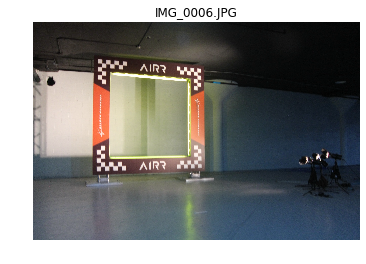

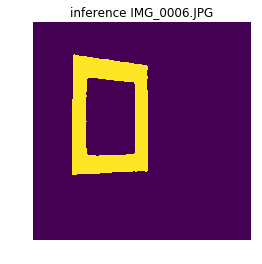

Contours: 2
* Shape 0 countours 118 with 4 approx
- Area: 79632.5
Harris corners: 4 approx corners: 4
--- First pass solution
4
* Shape 1 countours 192 with 4 approx
- Area: 198942.0
Harris corners: 4 approx corners: 4
--- First pass solution
4
[{'area': 79632.5, 'solution_pass': 1, 'corners': array([[327.55844, 220.5583 ],
       [601.44165, 241.55815],
       [323.5583 , 521.4417 ],
       [600.4417 , 522.4417 ]], dtype=float32)}, {'area': 198942.0, 'solution_pass': 1, 'corners': array([[240.61798, 128.43352],
       [678.42566, 171.66808],
       [683.4417 , 592.4417 ],
       [231.5583 , 605.4417 ]], dtype=float32)}]
** Two candidates. Selecting the smaller area


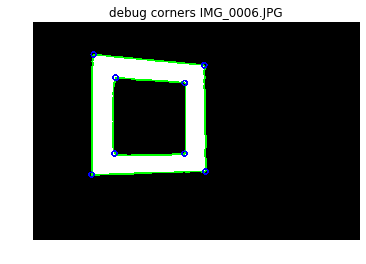

Solution [array([327.55844, 220.5583 , 601.44165, 241.55815, 600.4417 , 522.4417 ,
       323.5583 , 521.4417 ], dtype=float32)]


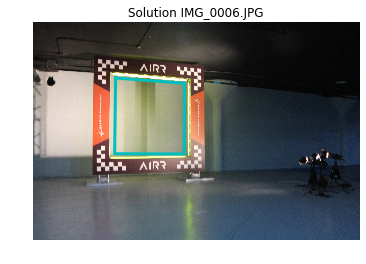

--------------------------------


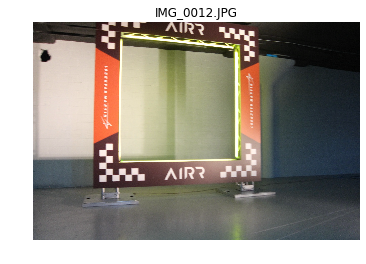

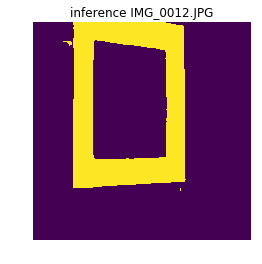

Contours: 4
* Shape 0 countours 17 with 4 approx
* Shape 1 countours 168 with 4 approx
- Area: 185716.0
Harris corners: 4 approx corners: 4
--- First pass solution
4
* Shape 2 countours 46 with 5 approx
* Shape 3 countours 153 with 4 approx
- Area: 422025.5
Harris corners: 5 approx corners: 4
Harris failed! using approx instead
--- First pass solution
4
[{'area': 185716.0, 'solution_pass': 1, 'corners': array([[367.8788  ,  72.192764],
       [786.28235 , 115.877754],
       [790.4417  , 531.4417  ],
       [361.5583  , 536.4417  ]], dtype=float32)}, {'area': 422025.5, 'solution_pass': 1, 'corners': array([[239,   0],
       [236, 657],
       [906, 630],
       [895,  14]], dtype=int32)}]
** Two candidates. Selecting the smaller area


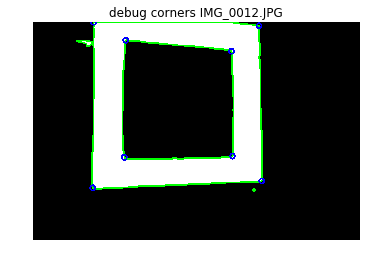

Solution [array([367.8788  ,  72.192764, 786.28235 , 115.877754, 790.4417  ,
       531.4417  , 361.5583  , 536.4417  ], dtype=float32)]


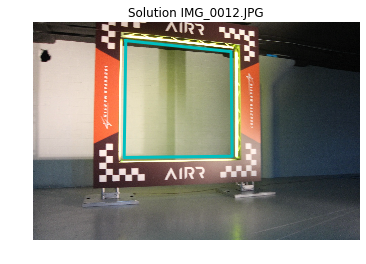

--------------------------------


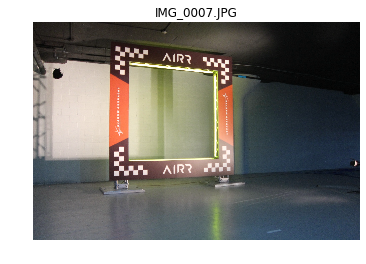

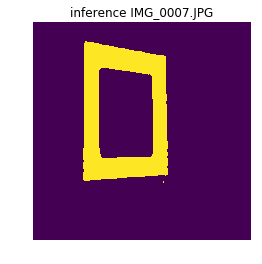

Contours: 3
* Shape 0 countours 11 with 6 approx
* Shape 1 countours 122 with 4 approx
- Area: 100900.0
Harris corners: 4 approx corners: 4
--- First pass solution
4
* Shape 2 countours 245 with 4 approx
- Area: 251145.5
Harris corners: 4 approx corners: 4
--- First pass solution
4
[{'area': 100900.0, 'solution_pass': 1, 'corners': array([[395.55844, 188.5583 ],
       [705.44165, 213.55815],
       [706.4417 , 531.4417 ],
       [404.5583 , 534.4417 ]], dtype=float32)}, {'area': 251145.5, 'solution_pass': 1, 'corners': array([[306.8788  ,  75.192764],
       [789.28235 , 133.87775 ],
       [797.4417  , 607.4417  ],
       [297.5583  , 627.4417  ]], dtype=float32)}]
** Two candidates. Selecting the smaller area


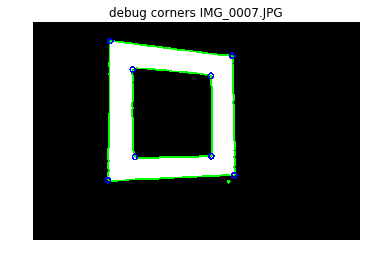

Solution [array([395.55844, 188.5583 , 705.44165, 213.55815, 706.4417 , 531.4417 ,
       404.5583 , 534.4417 ], dtype=float32)]


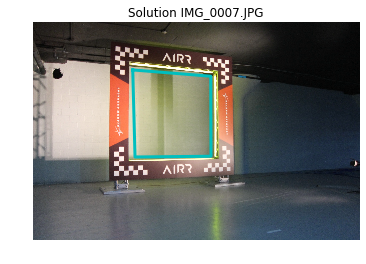

In [58]:
### --- Full Pipeline Test --- ###
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Core imports
import os
import time
import numpy as np
from matplotlib import pyplot as plt

# Estimation imports
import cv2

# Inference imports
from inference_alphapilot import inferenceAlphaPilot

# Estimator imports
from QuadEstimator import QuadEstimator

# Folders setup
input_folder = 'input_images/'
#input_folder = 'testing/images/'
model_checkpoint = 'checkpoints/deeplabv3plus-xception_epoch-11.pth'
# gt_json = 'training_GT_labels_v2.json'

# Load estimator
estimator = QuadEstimator()

# Load inference
# NOTE: set map_location='cpu' if CUDA is not available
inference = inferenceAlphaPilot(checkpoint_path=model_checkpoint,
                                conf_threshold=0.97,
                                imsize=512)

# Main loop
for f in os.listdir(input_folder):
    
    if not f.endswith('.jpg') and not f.endswith('.JPG'): continue
    
    print('--------------------------------')
    img_original = cv2.imread(input_folder+f)
    
    img_bgr = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    
    plt.axis('off')
    plt.imshow(img_original)
    plt.title(f)
    plt.show()
    
    img_mask = inference.inferenceOnNumpy(img_bgr)
    
    plt.axis('off')
    plt.imshow(img_mask)
    plt.title('inference '+f)
    plt.show()
    
    
    img_resized_mask = cv2.resize(img_mask, (1296, 864)) 
    
    corners, img_corners = estimator.process_img(img_resized_mask, gray=True)
    
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
    plt.title('debug corners '+f)
    plt.show()
    
    ordered_corners = order_points(corners)
    polys = [ordered_corners.flatten()]
    print('Solution', polys)
    
    plt.imshow(img_original)
    
    if polys is not None:
        for bb_i in polys:
            x1 = bb_i[0]
            y1 = bb_i[1]
            x2 = bb_i[2]
            y2 = bb_i[3]
            x3 = bb_i[4]
            y3 = bb_i[5]
            x4 = bb_i[6]
            y4 = bb_i[7]
            plt.plot([x1,x2,x3,x4,x1],
                     [y1,y2,y3,y4,y1],
                     color='c',linewidth=3
                    )
        plt.axis('off')
        plt.title('Solution '+f)
        plt.show()


# Reqs

```
### Mac environment installation:

pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
pip install imgaug

pip install torch torchvision


??
pip install git+https://github.com/aleju/imgaug 



```
